# Digital Epidemiology assignment 1

#### Livia Biggi 1793434 - Eugenio Bonifazi 1540750 - Adriano Fragomeni 1396786

The following project aims at reproducing the results of the experiment on Influenza-Like-Illness (ILI) for the United States, for Italy. The main experiment was conducted by McIver and Brownstein in 2014, and accurately estimated the week of peak activity more often than other state-of-the-art methods.
This project attempted to recreate the experiment of the paper aforementioned by building models using similar features and estimators; then it tried to find whether other models could somehow improve the accuracy of the predictions.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as ssm
from sklearn import preprocessing
import numpy as np
from scipy.stats import pearsonr, spearmanr
import pageviewapi
import wikipediaapi
from functools import reduce
import nltk
import string
from nltk.corpus import stopwords
import re
from collections import Counter
from urllib.request import urlopen
from bs4 import BeautifulSoup
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from pandas.plotting import autocorrelation_plot


h2o.init()

/Users/eugeniobonifazi/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "9.0.1"; Java(TM) SE Runtime Environment (build 9.0.1+11); Java HotSpot(TM) 64-Bit Server VM (build 9.0.1+11, mixed mode)
  Starting server from /Users/eugeniobonifazi/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gt/2g555kyd3zgc4frn9vrg_r7r0000gn/T/tmpjj5cdjw1
  JVM stdout: /var/folders/gt/2g555kyd3zgc4frn9vrg_r7r0000gn/T/tmpjj5cdjw1/h2o_eugeniobonifazi_started_from_python.out
  JVM stderr: /var/folders/gt/2g555kyd3zgc4frn9vrg_r7r0000gn/T/tmpjj5cdjw1/h2o_eugeniobonifazi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Rome
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_eugeniobonifazi_rnxm7s
H2O cluster total nodes:,1
H2O cluster free memory:,2 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## Data Collection and Scaling

Firstly, pageview data of the Italian Influenza page were collected and transformed to ISO format in order to access them by week.

In [2]:
def take_info(key,start,end):
    '''obtains the pageview data for a given wikipedia page'''
    dictionary_info=pageviewapi.per_article('it.wikipedia',key,start,end,access='all-access', agent='user', granularity='daily')
    date=[dictionary['timestamp'][:4]+'-'+dictionary['timestamp'][4:6]+'-'+dictionary['timestamp'][6:8] for dictionary in dictionary_info['items']]
    date_time=[dictionary['timestamp'] for dictionary in dictionary_info['items']]
    views=[dictionary['views'] for dictionary in dictionary_info['items']]
    if key=='Influenza':
        dataframe=pd.DataFrame({'Date':date,key:views,'Datetime':date_time})
    else:
        dataframe=pd.DataFrame({'Date':date,key:views})
    return dataframe

def take_total_Wikiviews(key,start,end):
    '''obtains the pageview data only for the mainpage of the Italian wikipedia'''
    dictionary_info=pageviewapi.aggregate(key, start,end, access='all-access',agent='user', granularity='daily')
    date=[dictionary['timestamp'][:4]+'-'+dictionary['timestamp'][4:6]+'-'+dictionary['timestamp'][6:8] for dictionary in dictionary_info['items']]
    views=[dictionary['views'] for dictionary in dictionary_info['items']]
    dataframe=pd.DataFrame({'Date':date,'Views':views})
    return dataframe

In [3]:
# Create Dataset and set the ISO format
click_influenza=take_info('Influenza','2015010100','2018123100')
start=click_influenza.Datetime.values[0]
end=click_influenza.Datetime.values[-1]

click_influenza['Date'] = pd.to_datetime(click_influenza['Date']).dt.strftime('%Y-%V')
click_influenza=click_influenza.groupby('Date').sum().sort_values(by='Date')
click_influenza['Week']=list(map(lambda date: int(date[-2:]),click_influenza.index))
click_influenza['Year']=list(map(lambda date: date[:4],click_influenza.index))

In [4]:
main_page = take_total_Wikiviews('it.wikipedia',start,end)
main_page['Date'] = pd.to_datetime(main_page['Date']).dt.strftime('%Y-%V')
main_page=main_page.groupby('Date').sum().sort_values(by='Date')
total_week=len(main_page)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(main_page[['Views']].values.astype(float))
main_page['Views'] = x_scaled

## Pageview Data Overview (Part 1.1)

In [5]:
def create_plot(dataset, year):
    date_time=list(filter(lambda date:date[:4]==str(year),dataset.index))
    df=dataset[dataset.index.isin(date_time)]
    fig, ax = plt.subplots(figsize=(12,6))
    sns.lineplot(x=df.index,y=df.Influenza, ax=ax,marker='o').set_xticklabels(labels=df.index,rotation=90)
    plt.title('Influenza Wiki Clicks ' + str(year))
    plt.xlabel('Week')
    plt.xticks(list(range(len(df.Year))), list(map(lambda x: x[-2:], df.index)))
    plt.ylabel('Clicks')

The graph below illustrates the Italian Influenza pageview data trends over a 12-month period from 2015 to 2018. As expected, the peaks tend to intensify during the ILI (peak) season; moreover, all time-series present a similar pattern throughout the year.

In [6]:
click_influenza.pivot_table('Influenza','Week','Year').plot(figsize=(13,8))
plt.title('Influenza page View time-series')
plt.ylabel('Click')

Text(0, 0.5, 'Click')

Graphs of individual years have been added below for clarity.

In [7]:
for year in range(2015,2019):
    create_plot(click_influenza, year)

## Influenza Pageview Data and Incidence - Initial Comparison (Part 1.2)

The Influnet data - i.e. the incidence of real ILI cases, - were only available for a limited time period: from the Autumn of 2015 (42nd week), until the Spring of 2018 (17th week). Furthemore, the data did not cover the entire 12-month period of each year, as they were only gathered during the ILI peak season - from mid-October until late April.
In order to account for this lack of data, the pageview data of the months not covered by Influnet were also removed from the dataset. As of the time of writing, this resulted in 84 total (weekly) observations covering the time period specified above.

In [8]:
influnet_15_16 = pd.read_csv('influnet/2015_2016.csv', sep=';')
influnet_15_16 = influnet_15_16.apply(lambda x: x.str.replace(',','.'))

influnet_16_17 = pd.read_csv('influnet/2016_2017.csv', sep=';')
influnet_16_17 = influnet_16_17.apply(lambda x: x.str.replace(',','.'))

influnet_17_18 = pd.read_csv('influnet/2017_2018.csv', sep=';')
influnet_17_18 = influnet_17_18.apply(lambda x: x.str.replace(',','.'))


# Transform the data using minmax processor
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(click_influenza[['Influenza']].values.astype(float))
click_influenza['Influenza'] = x_scaled

# merge datasets and scale the data
frames = [influnet_15_16, influnet_16_17, influnet_17_18]
influnet = pd.concat(frames, ignore_index=True)
influnet['Incidenza'] = list(map(float, influnet['Incidenza'].values))

# Transform the data using minmax processor
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(influnet[['Incidenza']].values.astype(float))
influnet['Incidenza'] = x_scaled


influnet = influnet.rename(index=str, columns={'Settimana' : 'Date'})
flu_data = pd.merge(influnet, click_influenza, on='Date')
flu_data = flu_data.set_index('Date')

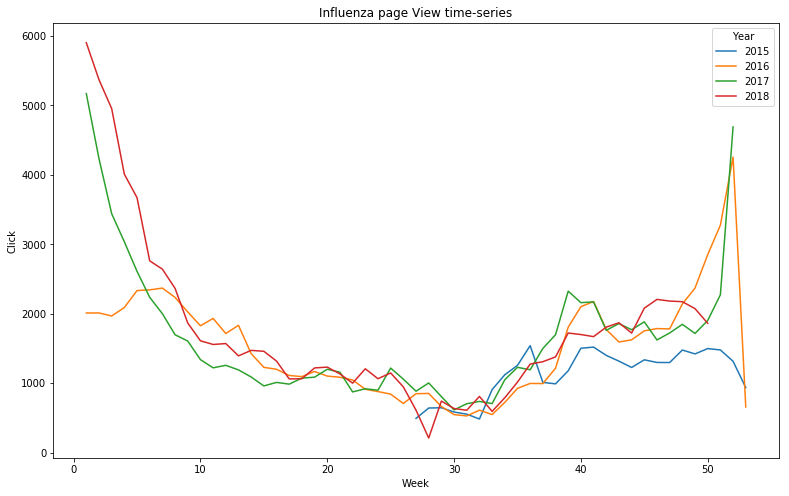

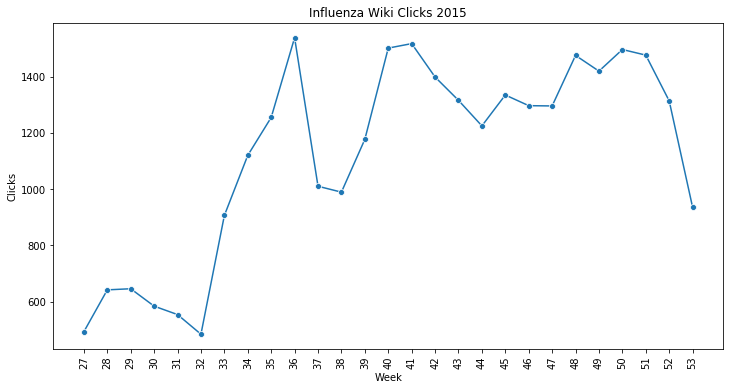

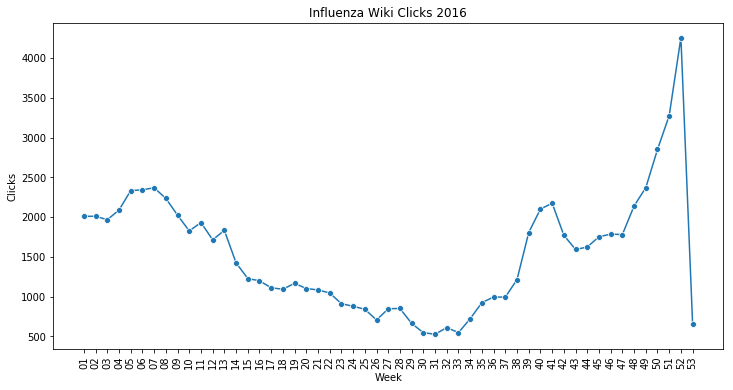

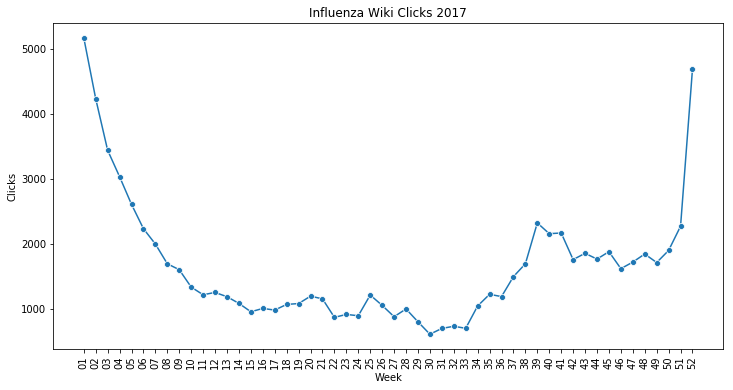

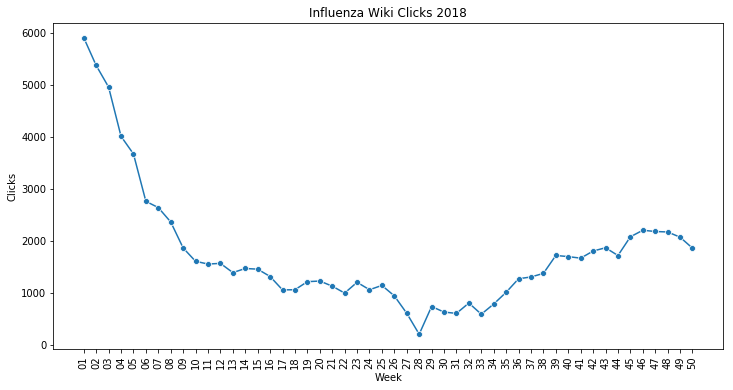

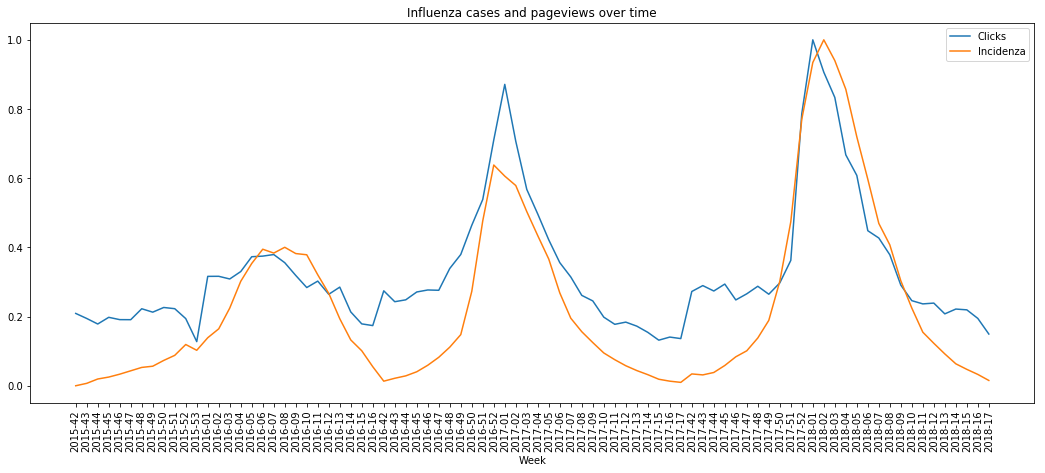

In [9]:
fig, ax = plt.subplots(figsize=(18,7))
plt.plot(flu_data.index, flu_data.Influenza, label='Clicks')
plt.plot(flu_data.index, flu_data.Incidenza, label='Incidenza')
plt.title('Influenza cases and pageviews over time')
plt.xlabel('Week')
plt.xticks(list(range(len(flu_data.Week))), flu_data.index, rotation=90)
plt.ylabel('')
ax.legend()
plt.show()

The graph above shows the plot of the (scaled) Influnet and Influenza pageview data for the available time period. Since the pageview data appear to have a similar pattern over time as the ILI cases, it could be argued that it might be a potentially good predictor of the latter; though a future model should take into account more variables.
The two variables hence present a significant positive correlation, which is computed below using both Pearson and Spearman correlation coefficients.

In [10]:
pearson_coeff = pearsonr(flu_data['Incidenza'], flu_data['Influenza'])
spearman_coeff = spearmanr(flu_data['Incidenza'],  flu_data['Influenza'])
print('Pearson coefficient', pearson_coeff)
print('Spearman coefficient', spearman_coeff)

Pearson coefficient (0.9205795256419327, 3.138178536674248e-35)
Spearman coefficient SpearmanrResult(correlation=0.8380750852196114, pvalue=2.747992172547472e-23)


The chosen measures of correlation compute similarities between variables that present linear (Pearson) and monotonic relationships (Spearman), which result in a significant positive correlation (with p-values < 0.0001).

## Independent Variables Choice and Model Selection (Part 2.1 - 2.2)

In [11]:
def set_pages(pages,start,end, total_week):
    '''creates dataframe of the scaled pageview data of given wikipedia pages'''
    list_df_symptoms=[]
    for page in pages:
        try:
            df=take_info(page,start,end)
            df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%V')
            df= df.groupby('Date').sum().sort_values(by='Date')
            if len(df)== total_week:
                min_max_scaler = preprocessing.MinMaxScaler()
                x_scaled = min_max_scaler.fit_transform(df[[page]].values.astype(float))
                df[page] = x_scaled
                list_df_symptoms.append(df)
        except:
            continue
    symptoms=reduce(lambda x,y:pd.merge(x,y,on='Date'),list_df_symptoms)
    return symptoms

def findinfo_linked_page(page,influnet_data,start,end,total_week,lst=False):
    '''find the most correlated pages among those that are pointed (i.e. linked) to by the Influenza page'''
    if lst==False:
        wiki_wiki = wikipediaapi.Wikipedia('it')
        page_wiki = wiki_wiki.page(page)
        wiki_pages=list(page_wiki.links.keys())
    else:
        wiki_pages=page
    symptoms=set_pages(wiki_pages,start,end,total_week)
    symptoms = pd.merge(symptoms, influnet, on='Date')
    symptoms_corr = symptoms.corr()
    return symptoms,symptoms_corr

def max_min_correlations(corr,nmax,nmin):
    index_max_30=list(corr.nlargest(nmax,'Incidenza')['Incidenza'].index)
    index_min_30=list(corr.nsmallest(nmin,'Incidenza')['Incidenza'].index)
    indeces=index_max_30+index_min_30
    heatmap=corr.loc[indeces,indeces]
    return heatmap

def bag_of_word(page):
    '''identifies the most common words in the Influenza page on wikipedia'''
    wiki_wiki = wikipediaapi.Wikipedia('it')
    page_wiki = wiki_wiki.page(page)
    txt=page_wiki.text

    txt = re.sub(r'[^\w\s]',' ',txt)
    filtered_words = [word.lower() for word in txt.split() if word.lower() not in stopwords.words('italian') 
                      and word not in list(string.ascii_letters)]
    return Counter(filtered_words).most_common(20)

def take_pointed_page(page_wiki,page_part,words):
    '''finds all pages that point to the Influenza page'''
    page =urlopen(page_part)
    soup = BeautifulSoup(page, 'lxml')
    for el in soup.find_all('li'):
        if el.attrs=={}:
            words.append(el.find('a').text)
    try:        
        page_=find_following(soup)
    except UnboundLocalError:
        page_=None
    if page_==None:
        return set(words)
    page_part=page_wiki+page_
    return take_pointed_page(page_wiki,page_part,words)

def find_following(soup):
    '''parses pages'''
    for el in soup.find_all('a'):
        if el.text=='successivi 50':
            page=el.get('href')
    return page

The choice of relevant independent variables was based on different methods and criteria both from an analytical perspective and from a professional one.

On one hand, we measured the correlation of wikipedia pages that were either pointed to by the Influenza page or that pointed to it, and we chose those that presented the highest correlation (measured using the Pearson coefficient) with the Incidence variable. Furthermore, we included a 'bag-of-words' analysis, which found the most common words (that did not have hyperlinks) in the Influenza page on Wikipedia, and measured their correlation in relation to the Incidence.

On the other hand, since correlation may not be the best indicator (and predictor) of real ILI cases, we turned to doctors to increase our pool of potentially-viable variables, and investigated all pages that are scientifically related to Influenza, such as 'Orthomyxoviridae' and 'Avvelenamento da Paracetamolo'.

The chunks below find relevant pages using the methods defined above.

In [12]:
# pages pointed by the Influenza page
df_symptoms_wiki,symptoms_corr_wiki=findinfo_linked_page('Influenza',influnet,start,end,total_week)
heatmap_wiki=max_min_correlations(symptoms_corr_wiki,50,10)

In [13]:
# pages pointing to the Influenza page
page_wiki_point='https://it.wikipedia.org/wiki/Speciale:PuntanoQui/Influenza'
mainpage_wiki='https://it.wikipedia.org'
words=list(take_pointed_page(mainpage_wiki,page_wiki_point,[]))
df_symptoms_w,symptoms_corr_w=findinfo_linked_page(words,influnet,start,end,total_week,lst=True)
heatmap_w=max_min_correlations(symptoms_corr_w,90,10)

In [14]:
# pages suggested by doctors
list_elements=['Farmaci antivirali','Antivirale','Food and Drug Administration','Avvelenamento da paracetamolo','Ketoprofene',
               'FANS','Vaccino antinfluenzale','Farmaco antalgico','Acido acetilsalicilico','Antinfiammatorio',
               'Dolore addominale','Vertigini','Dispnea','Mal di testa','Fatica','Otalgia','Disfonia','Faringite','Starnuto',
               'Rinorrea','Orthomyxoviridae','Influenzavirus A','Mutazione genetica','Influenza suina', 'Epidemia','Pandemia',
               'Contagio','Espettorato','Organizzazione mondiale della sanità','Malattia infettiva','Febbre','Cefalea',
               'Astenia','Mialgia','Sudorazione','Brivido','Contrazione muscolare','Tosse','Nausea','Vomito','Diarrea',
               'Periodo di incubazione','Contagiosità','Paracetamolo','Ibuprofene','Diclofenac','Oseltamivir','Zanamivir',
               'Amantadina','Polmonite','Otite','Sinusite','Sindrome di Reye','Miocardite','Encefalite','Rabdomiolisi',
               'Tasso di mortalità','Tasso di mortalità infantile','Antigene','Vaccinazione','Somministrazione (farmacologia)',
               'Agenzia italiana del farmaco','Immunità di gregge','Agenzia europea per i medicinali']

df_symptoms_doct,symptoms_corr_doct=findinfo_linked_page(list_elements,influnet,start,end,total_week,lst=True)
heatmap_doct=max_min_correlations(symptoms_corr_doct,30,10)

In [15]:
# bag-of-words method
bag_Influenza=bag_of_word('Influenza')
bag_Influenza
lst_elements=['Virus (biologia)','Stipite virale','Infezione','Malattia']
df_symptoms_bog,symptoms_corr_bog=findinfo_linked_page(lst_elements,influnet,start,end,total_week,lst=True)
heatmap_bog=max_min_correlations(symptoms_corr_bog,2,2)

Next, we selected the most correlated pages to Incidenza from each group, and studied their relevancy with respect to the topic of Influenza. As a matter of fact, we discarded pageviews of 'Influenza di Hong Kong', 'Astrologia Occidentale', and others - which we found in the group of pages pointing to Influenza.

We also tried to minimise the multi-collinearity (which we also controlled for in one of our models) by removing the majority of  collinear independent variables.

In [16]:
selected_vars = ['Paracetamolo', 'Antibiotico', 'Polmonite','Rinite medicamentosa', 'Virus (biologia)', 'Influenza',
                 'Tosse post-virale', 'Bronchiolite', 'Virus respiratorio sinciziale umano','Antivirali',
                 'Virus parainfluenzali umani','Tonsillite', 'Laringospasmo','Orthomyxoviridae', 'Febbre', 'Antivirale',
                 'Ibuprofene', 'Faringite','Starnuto', 'Pandemia']


selected_df, selected_df_corr = findinfo_linked_page(selected_vars, influnet,start,end,total_week, lst=True)


all_data = selected_df.set_index('Date')
Incidenza = all_data['Incidenza']
del all_data['Incidenza']
all_data.insert(loc=0, column='Incidenza', value=Incidenza)
all_data.insert(loc=1, column='Main Page', value=main_page['Views'])

The full list of the final selected variables can be found below.

In [17]:
print('Selected Variables: ', ', '.join(selected_vars))

Selected Variables:  Paracetamolo, Antibiotico, Polmonite, Rinite medicamentosa, Virus (biologia), Influenza, Tosse post-virale, Bronchiolite, Virus respiratorio sinciziale umano, Antivirali, Virus parainfluenzali umani, Tonsillite, Laringospasmo, Orthomyxoviridae, Febbre, Antivirale, Ibuprofene, Faringite, Starnuto, Pandemia


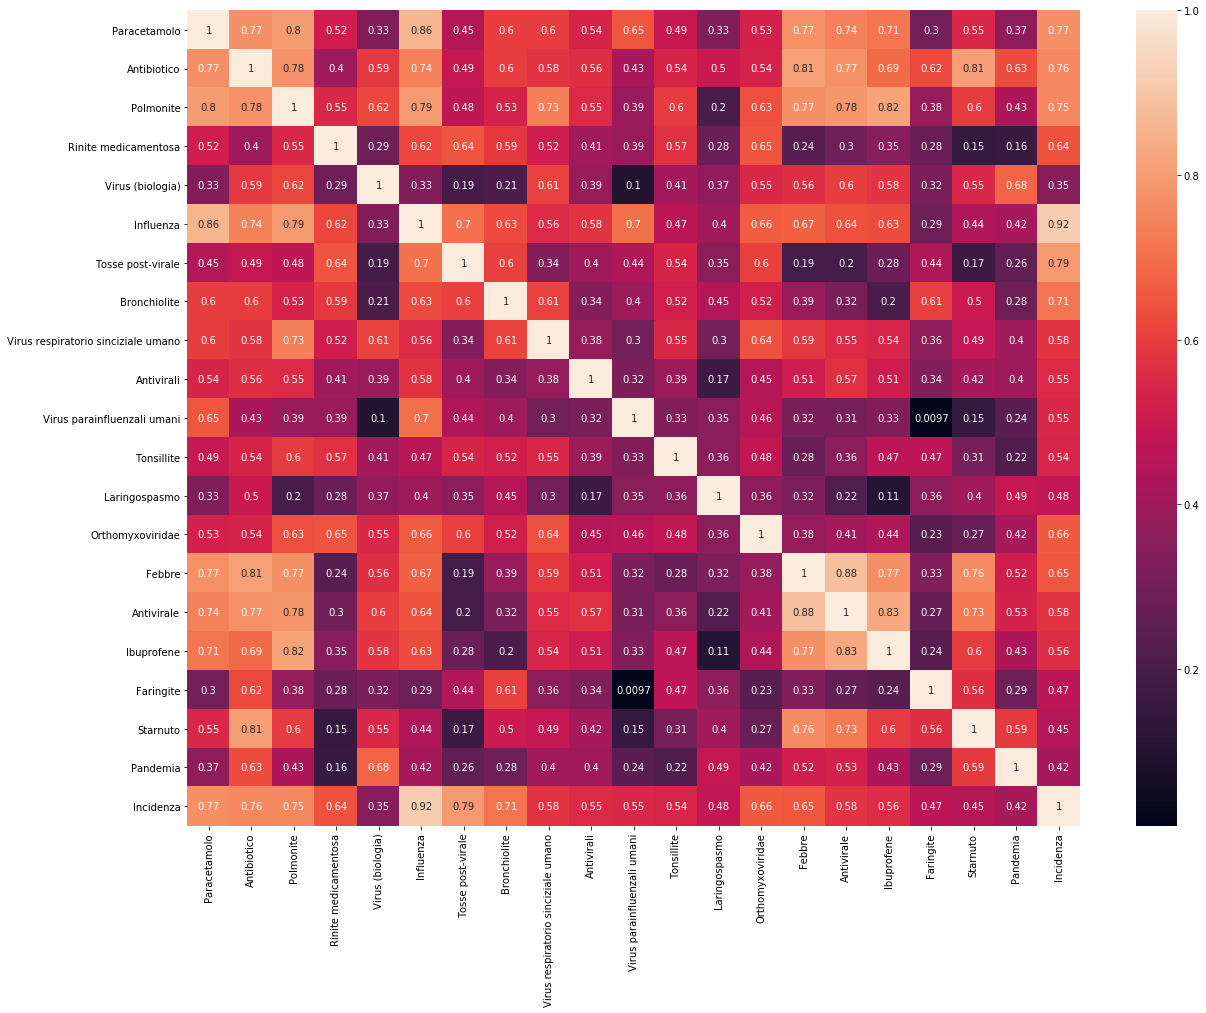

In [18]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(selected_df_corr,annot=True)
plt.show()

Although we selected the independent variables based on their correlation with Incidenza, we decided to keep those that presented relatively low levels of correlation (e.g. 'Virus (biologia)' with 0.35); the rationale behind this is that even though they might not appear to be as meaningful as more correlated variables, they might still be important and significant in the model. In the same way, we kept highly-correlated variables even though they may be later removed by our models' feature selection methods.

In [19]:
def highest_incidence_corr(corr_mat, t):
    '''returns the list of variables which have a correlation with "Incidenza" greater than t'''
    incid_corr = corr_mat.sort_values('Incidenza', ascending=False)['Incidenza'].drop('Incidenza')
    for i in incid_corr.index:
        if incid_corr[i]<t:
            incid_corr=incid_corr.drop(str(i))
    return incid_corr

In [20]:
incid_corr = highest_incidence_corr(selected_df_corr, 0)
incid_corr

Influenza                              0.920580
Tosse post-virale                      0.793243
Paracetamolo                           0.770596
Antibiotico                            0.756138
Polmonite                              0.754686
Bronchiolite                           0.713078
Orthomyxoviridae                       0.659290
Febbre                                 0.650294
Rinite medicamentosa                   0.640859
Antivirale                             0.579402
Virus respiratorio sinciziale umano    0.577095
Ibuprofene                             0.560280
Antivirali                             0.552027
Virus parainfluenzali umani            0.547738
Tonsillite                             0.540450
Laringospasmo                          0.484771
Faringite                              0.468455
Starnuto                               0.452875
Pandemia                               0.417254
Virus (biologia)                       0.349094
Name: Incidenza, dtype: float64

Plots of all independent variables' pageviews and Incidence cases over time are shown below. The order of the plots reflects their (decreasing) degree of correlation to the dependent variable.

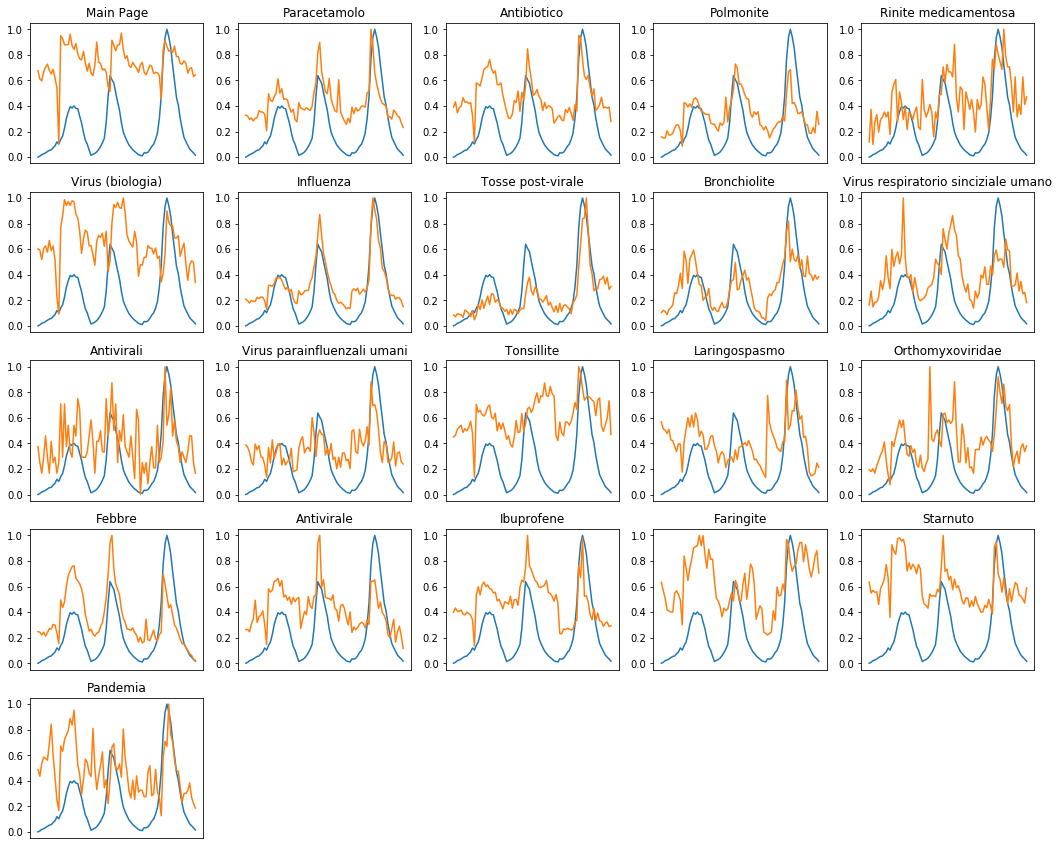

In [21]:
# comparison of variables' pageviews with real ILI cases
pairs = list(('Incidenza', i) for i in all_data.columns[1:])
fig = plt.figure(figsize=(18,15))

for i in range(0, len(pairs)):
    ax = fig.add_subplot(len(pairs)//4, 5, i+1)
    ax.plot(all_data.index, all_data.Incidenza)
    ax.plot(all_data.index, all_data[pairs[i][1]])  
    plt.title(pairs[i][1])
    plt.xticks(list(range(0,0)), all_data.index)
    
plt.show()

The original pool of independent variables selected using the methods defined in the sections above was clearly much larger than those selected for our models - out of the final twenty variables the one that presented the highest correlation with Incidence was 'Influenza', with a Pearson coefficient of 0.92.
Yet, this was the result of the removal of many highly-correlated variables, that however exhibited multicollinearity (in particular with 'Influenza') and were hence removed. Of those, 'Oseltamivir' (which also had a 0.92 correlation with Incidence) and 'Pandemia Influenzale', with 0.88 correlation to Incidence. As expected, we did not find any other wikipedia page that presented a higher correlation to Incidence than 'Influenza' or 'Oseltamivir'.

Even though the Italian Wikipedia Main Page was added to our models as an independent variable, this was done not just to add explanatory power to the models, but to include an extra regularisation factor into our analysis.

## Models (Part 3.1)

Among the variables we found during our analyses, those that presented a high correlation to the real ILI cases or that could be potentially meaningful variables in the model were kept for the model; the final dataset thus comprises parameters with various degrees of correlation to the dependent variable, and it includes the pageview of the Italian Wikipedia Main Page as a regularisation parameter.

The main problem that arose during the preparation of our data concerned how to meaningfully build a model that could accurately predict real Influenza cases, given that the total number of observations available was 84 total weeks. As previously discussed, we removed data of non-peak Influenza season in order to analyse them against real ILI cases, since the Influnet data were not available during non-peak periods.
Given the small pool of observations to perform the training of our model, we had to choose among equally-viable options to predict real-world ILI cases described in McIver and Brownstein's paper: divide the dataset into a training set and a test set (e.g. train the models on the data up to Spring 2017, and then try to predict the Autumn 2017-Spring 2018 ILI peak); train the models on the entire dataset and check how close the predictions were to the real-world data; or randomly split the dataset into train and test. The former cases provide a good metre of comparison and would be of easy interpretation, whilst the latter would be trickier to use for a time-series analysis such as this one.

Since the dataset consists of time-series/seasonal data, we believed that a randomly-split train and test would not be representative of the dataset's underlying features (such as seasonal patterns and trends), thereby hindering the prediction goal of this project. The method was thus not taken into consideration in our analysis.

We therefore tried the former two approaches, and reported the results below for comparison.

Furthermore, we used the Akaike Information Criterion (AIC) to investigate the relative reliability of the statistical models presented in this project - following the footsteps of McIver and Brownstein's paper.

### Method 1: Train set using the entire dataset

In [22]:
def aic(y, y_pred, X):
    k= len(X.columns)
    sse = np.sum(np.square(np.asarray(y)-np.asarray(y_pred)))
    aic = 2*k - 2*np.log(sse)
    return aic

def plot_prediction(train_pred,test_pred,title,data_incidenza,data,split=True):
    fig, ax = plt.subplots(figsize=(18,7))
    if split:
        prediction=pd.concat((train_pred, test_pred))
        plt.axvline(x=56,color='black',alpha=0.3,linestyle='--')
    else:
        prediction=train_pred
    plt.plot(data.index,prediction, label='Model')
    plt.plot(data.index, data.Incidenza, label='Incidenza')
    plt.title(title)
    plt.xlabel('Date')
    plt.xticks(list(range(len(data_incidenza.index))), data_incidenza.index, rotation=90)
    plt.ylabel('')
    ax.legend()
    plt.show()

### Poisson Model + LASSO ( McIver and Brownstein)

Since the main goal of this project was to reproduce the results obtained by McIver and Brownstein's model, we first decided to construct our model such that it would be as similar as possible to that defined in their paper. Therefore, we began by designing a Poisson model with a Log-link function, that would not only exploit the regularisation method in order to find a suitable lambda, as well as the LASSO feature-selection method (which sets meaningless variables to 0).

In [23]:
boot = h2o.H2OFrame(resample(all_data, random_state=1314).iloc[:60,:])
predictors = list(all_data.columns[1:])
y = all_data.columns[0]

glm_model = H2OGeneralizedLinearEstimator(nfolds=10, remove_collinear_columns=True, family='poisson', link='log', lambda_search = True, alpha=1)
glm_model.train(x=predictors, y=y, training_frame=h2o.H2OFrame(all_data), validation_frame=boot)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [24]:
table = glm_model._model_json['output']['coefficients_table']
table.as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-3.220028,-1.906375
1,Main Page,-1.467095,-0.187087
2,Paracetamolo,0.000000,0.000000
3,Antibiotico,0.000000,0.000000
4,Polmonite,0.309043,0.041882
5,Rinite medicamentosa,0.184896,0.035401
6,Virus (biologia),1.357169,0.251630
7,Influenza,0.940344,0.175971
8,Tosse post-virale,0.671799,0.120171
9,Bronchiolite,1.984049,0.332032


As expected, not all selected variables were considered meaningful for our model, such as 'Paracetamolo' and 'Antibiotico', which presented a correlation coefficient of 0.77 and 0.75 respectively, and that were thus removed from it.

In [25]:
prediction = glm_model.predict(h2o.H2OFrame(all_data.iloc[:,1:])).as_data_frame()

h2o_mse=mean_squared_error(all_data.Incidenza.values, prediction)
h2o_rmse = sqrt(h2o_mse)
print('R^2:', glm_model.r2())
print('MSE:', h2o_mse)
print('RMSE:', h2o_rmse)
print('AIC:', aic(all_data.iloc[:,1], prediction, all_data.iloc[:,1:]))

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
R^2: 0.9423297186032767
MSE: 0.003418712986473075
RMSE: 0.058469761299949526
AIC: 26.508684973575903


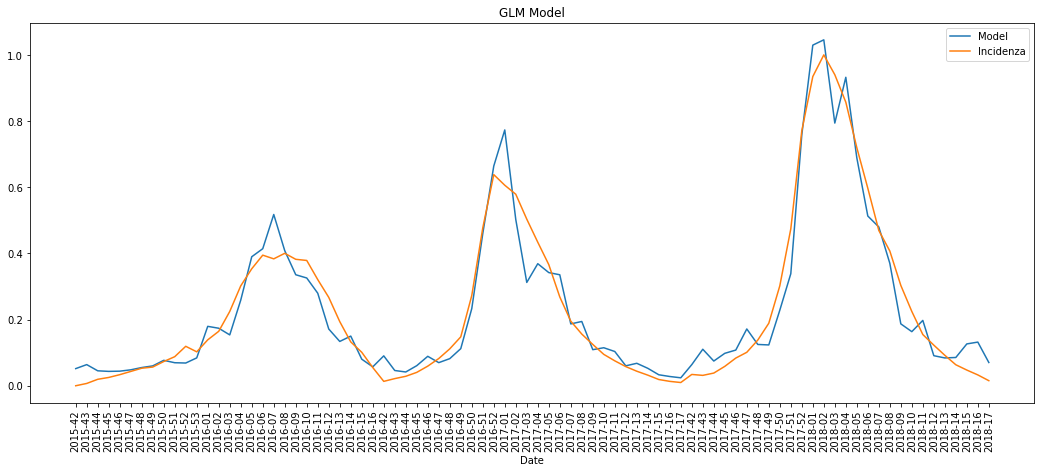

In [26]:
plot_prediction(prediction,None,'GLM Model',flu_data,all_data,split=False)

### LASSO Model

In [27]:
X=all_data.iloc[:,1:]
Y=all_data['Incidenza'][:]

grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': np.arange(0.0001,1,0.0001)},n_jobs=-1,cv=10)
grid.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
Lasso_model_final= Lasso(alpha=grid.best_estimator_.alpha).fit(X, Y)
predict_lasso=Lasso_model_final.predict(X)
pd.DataFrame(list(zip(X.columns, Lasso_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.000000
1,Paracetamolo,0.000000
2,Antibiotico,0.000000
3,Polmonite,0.000000
4,Rinite medicamentosa,0.000000
5,Virus (biologia),-0.000000
6,Influenza,0.602905
7,Tosse post-virale,0.420467
8,Bronchiolite,0.103085
9,Virus respiratorio sinciziale umano,0.000000


In [29]:
lasso_mse=mean_squared_error(Y,predict_lasso)
lasso_rmse = sqrt(lasso_mse)

print("R^2: {}".format(Lasso_model_final.score(X, Y)))
print('MSE:', lasso_mse)
print('RMSE:', lasso_rmse)
print('AIC:', aic(all_data.iloc[:,1], predict_lasso,all_data.iloc[:,1:]))

R^2: 0.9275701822416291
MSE: 0.004293663284756155
RMSE: 0.06552605042848345
AIC: 35.602822184889405


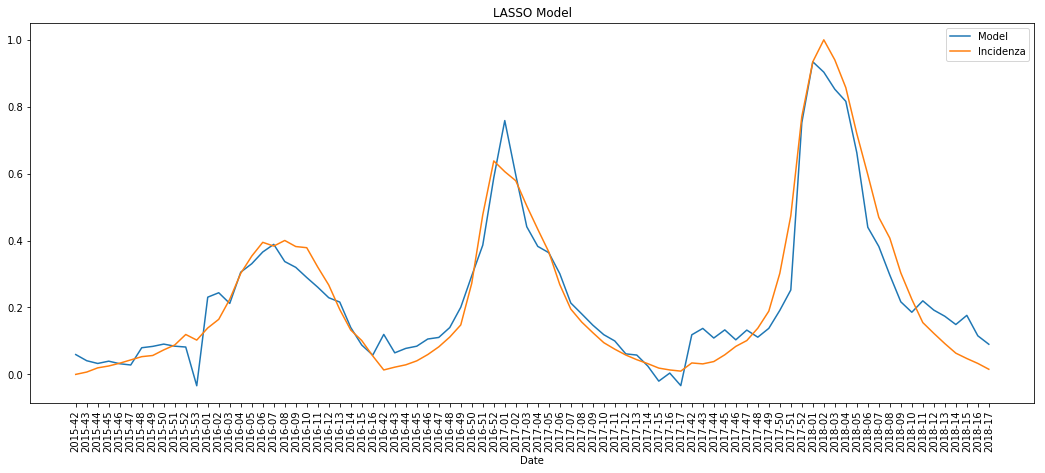

In [30]:
plot_prediction(predict_lasso,None,'LASSO Model',flu_data,all_data,split=False)

### Ridge Model

In [31]:
clf = GridSearchCV(estimator=Ridge(), param_grid={'alpha': np.arange(0.0001,1,0.0001)},cv=10,n_jobs=-1)
clf.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [32]:
Ridge_model_final= Ridge(alpha=clf.best_estimator_.alpha).fit(X, Y)
predict_ridge=Ridge_model_final.predict(X)

pd.DataFrame(list(zip(X.columns, Ridge_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.106899
1,Paracetamolo,0.068101
2,Antibiotico,0.084682
3,Polmonite,0.101003
4,Rinite medicamentosa,0.084749
5,Virus (biologia),-0.072262
6,Influenza,0.301765
7,Tosse post-virale,0.322270
8,Bronchiolite,0.133176
9,Virus respiratorio sinciziale umano,0.022145


In [33]:
ridge_mse=mean_squared_error(Y,predict_ridge)
ridge_rmse = sqrt(lasso_mse)

print("R^2: {}".format(Ridge_model_final.score(X, Y)))
print('MSE:', lasso_mse)
print('RMSE:', lasso_rmse)
print('AIC:', aic(all_data.iloc[:,1], predict_ridge,all_data.iloc[:,1:]))

R^2: 0.9262119321236488
MSE: 0.004293663284756155
RMSE: 0.06552605042848345
AIC: 35.6111111678299


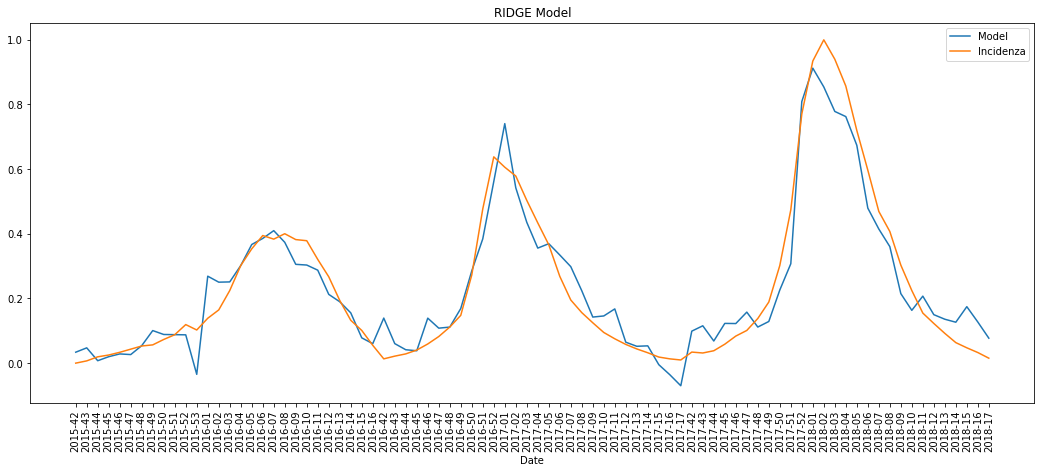

In [34]:
plot_prediction(predict_ridge,None,'RIDGE Model',flu_data,all_data,split=False)

### Linear Regression Model

In [35]:
reg = LinearRegression().fit(X, Y)
predict_linear=reg.predict(X)

In [36]:
pd.DataFrame(list(zip(X.columns, reg.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.208072
1,Paracetamolo,-0.319439
2,Antibiotico,0.121894
3,Polmonite,0.217927
4,Rinite medicamentosa,0.017172
5,Virus (biologia),-0.132894
6,Influenza,0.456021
7,Tosse post-virale,0.409926
8,Bronchiolite,0.316221
9,Virus respiratorio sinciziale umano,-0.039440


In [37]:
lin_mse=mean_squared_error(Y,predict_linear)
lin_rmse=sqrt(lin_mse)
print("R^2: {}".format(reg.score(X, Y)))
print('MSE:', lin_mse)
print('RMSE:', lin_rmse)
print('AIC:', aic(all_data.iloc[:,1], predict_linear,all_data.iloc[:,1:]))

R^2: 0.9630447177404119
MSE: 0.002190721218506108
RMSE: 0.046805140940991814
AIC: 35.52486574141265


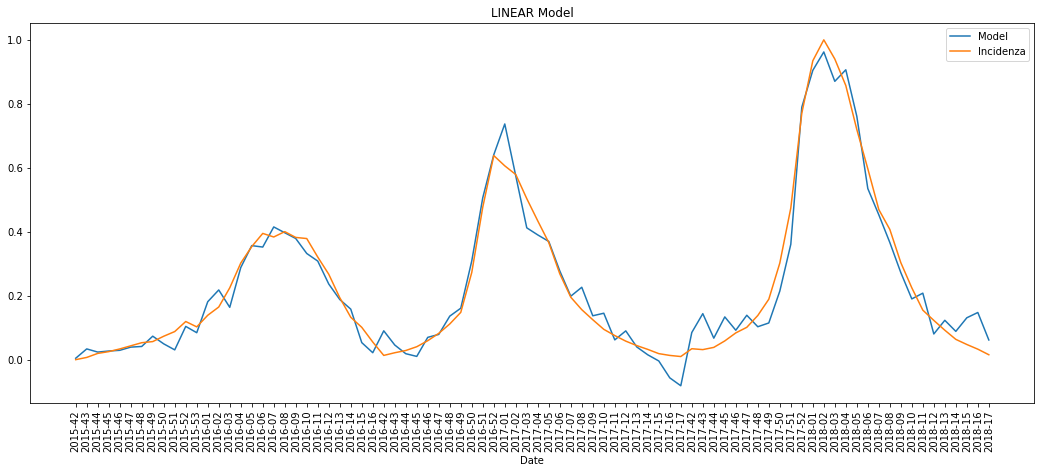

In [38]:
plot_prediction(predict_linear,None,'LINEAR Model',flu_data,all_data,split=False)

Although all models seem to have a good fit with the real-world data and given that they all have an R-squared larger than 0.9 and that their MSE are very low (less than 0.005), the lack of a test set suggests that they may not perform as well as it might appear. Even though the Linear Model has the largest R-squared (0.96), the Poisson model appears to be the best-performing in relative terms - with an AIC score of 26.

The same models are analysed below by splitting the dataset into a training and a test set.

### Method 2: Dataset split into training and test set

### Poisson Model + LASSO ( McIver and Brownstein)

In [39]:
train_ = all_data.iloc[:56,:]
test_ = all_data.iloc[56:,:]

predictors = list(train_.columns[1:])
y = train_.columns[0]

glm_model = H2OGeneralizedLinearEstimator(nfolds=10, remove_collinear_columns=True, family='poisson', link='log', lambda_search=True, alpha=1)
glm_model.train(x=predictors, y=y, training_frame=h2o.H2OFrame(all_data))

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [40]:
table = glm_model._model_json['output']['coefficients_table']
table.as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-2.835792,-1.658007
1,Main Page,0.000000,0.000000
2,Paracetamolo,0.000000,0.000000
3,Antibiotico,0.000000,0.000000
4,Polmonite,0.000000,0.000000
5,Rinite medicamentosa,0.000000,0.000000
6,Virus (biologia),0.000000,0.000000
7,Influenza,1.158316,0.216761
8,Tosse post-virale,0.867927,0.155255
9,Bronchiolite,0.764427,0.127927


In [41]:
test_prediction = glm_model.predict(h2o.H2OFrame(test_)).as_data_frame()
train_prediction = glm_model.predict(h2o.H2OFrame(train_)).as_data_frame()

h2o_mse_train=mean_squared_error(train_.Incidenza.values, train_prediction)
h2o_rmse_train = sqrt(h2o_mse_train)
h2o_mse_test=mean_squared_error(test_.Incidenza.values, test_prediction)
h2o_rmse_test = sqrt(h2o_mse_test)
print('\n')
print('R^2 Train:', glm_model.r2())
print('\n')
print('Train MSE:', h2o_mse_train)
print('Train RMSE:', h2o_rmse_train)
print('Train AIC:', aic(all_data.iloc[:56,1], train_prediction, all_data.iloc[:56,1:]))
print('\n')
print('Performance on Test Set:')
print('\n')
glm_model.model_performance(test_data=h2o.H2OFrame(test_))

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


R^2 Train: 0.819270408011757


Train MSE: 0.007467431100380973
Train RMSE: 0.08641429916617373
Train AIC: 28.097970084977227


Performance on Test Set:


Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.017206265454796112
RMSE: 0.13117265513359144
MAE: 0.11391343476409324
RMSLE: 0.09617330299777058
R^2: 0.8346582122252251
Mean Residual Deviance: 0.06957135881033576
Null degrees of freedom: 27
Residual degrees of freedom: 21
Null deviance: 9.602690480834736
Residual deviance: 1.9479980466894014
AIC: 46.2267108724194


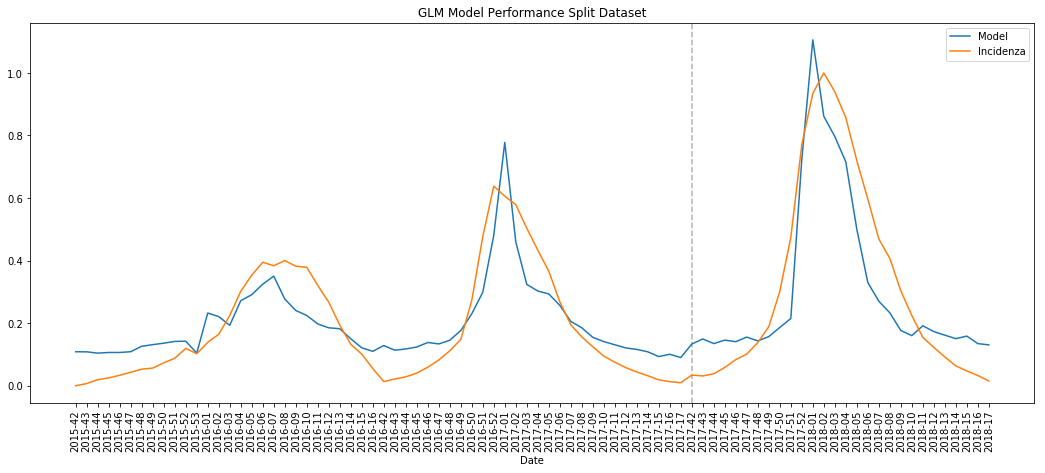

In [42]:
plot_prediction(train_prediction,test_prediction,'GLM Model Performance Split Dataset',flu_data,all_data)

### LASSO Model

In [43]:
X_train=all_data.iloc[:56,1:]
Y_train=all_data['Incidenza'][:56]
X_test=all_data.iloc[56:,1:]
Y_test=all_data['Incidenza'][56:]

In [44]:
grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': np.arange(0.0001,1,0.0001)},n_jobs=-1,cv=10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [45]:
Lasso_model_final= Lasso(alpha=grid.best_estimator_.alpha).fit(X_train, Y_train)
pd.DataFrame(list(zip(X_train.columns, Lasso_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.028078
1,Paracetamolo,0.000000
2,Antibiotico,-0.000000
3,Polmonite,0.098534
4,Rinite medicamentosa,0.006570
5,Virus (biologia),-0.000000
6,Influenza,0.153218
7,Tosse post-virale,0.000000
8,Bronchiolite,0.000000
9,Virus respiratorio sinciziale umano,0.052471


In [46]:
# Train Set
labels_lasso_train=Lasso_model_final.predict(X_train)

lasso_mse=mean_squared_error(Y_train,labels_lasso_train)
lasso_rmse = sqrt(lasso_mse)

print("R^2 train: {}".format(Lasso_model_final.score(X_train, Y_train)))
print('MSE train:', lasso_mse)
print('RMSE train:', lasso_rmse)
print('AIC train:', aic(all_data.iloc[:56,1], labels_lasso_train,all_data.iloc[:56,1:]))

R^2 train: 0.9419438101513437
MSE train: 0.0017347793286684183
RMSE train: 0.0416506822113206
AIC train: 36.114697329244116


In [47]:
# Test Set
labels_lasso_test = Lasso_model_final.predict(X_test)

lasso_mse=mean_squared_error(Y_test,labels_lasso_test)
lasso_rmse = sqrt(lasso_mse)

print("R^2 test: {}".format(Lasso_model_final.score(X_test, Y_test)))
print('MSE test:', lasso_mse)
print('RMSE test:', lasso_rmse)
print('AIC test:', aic(all_data.iloc[56:,1],labels_lasso_test,all_data.iloc[56:,1:]))

R^2 test: 0.12071008525160654
MSE test: 0.09150315950955677
RMSE test: 0.3024948917082019
AIC test: 37.18992275706309


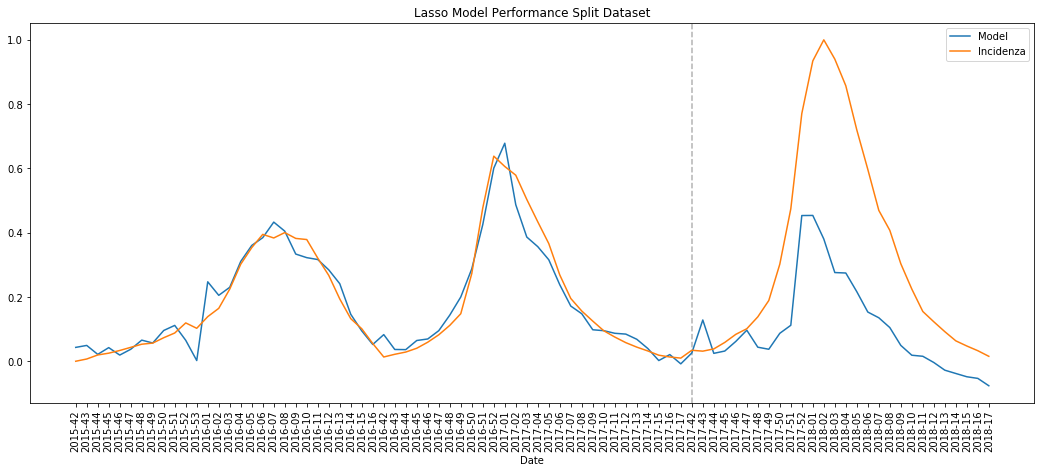

In [48]:
plot_prediction(pd.Series(labels_lasso_train),pd.Series(labels_lasso_test),'Lasso Model Performance Split Dataset',flu_data,all_data)

### Ridge Model

In [49]:
clf = GridSearchCV(estimator=Ridge(), param_grid={'alpha': np.arange(0.0001,1,0.0001)},cv=10,n_jobs=-1)
clf.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
Ridge_model_final= Ridge(alpha=clf.best_estimator_.alpha).fit(X_train, Y_train)
pd.DataFrame(list(zip(X_train.columns, Lasso_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.028078
1,Paracetamolo,0.000000
2,Antibiotico,-0.000000
3,Polmonite,0.098534
4,Rinite medicamentosa,0.006570
5,Virus (biologia),-0.000000
6,Influenza,0.153218
7,Tosse post-virale,0.000000
8,Bronchiolite,0.000000
9,Virus respiratorio sinciziale umano,0.052471


In [51]:
# Train Set
labels_ridge_train=Ridge_model_final.predict(X_train)

ridge_mse=mean_squared_error(Y_train,labels_ridge_train)
ridge_rmse = sqrt(ridge_mse)

print("R^2 train: {}".format(Ridge_model_final.score(X_train, Y_train)))
print('MSE train:', ridge_mse)
print('RMSE train:', ridge_rmse)
print('AIC train:', aic(all_data.iloc[:56,1], labels_ridge_train,all_data.iloc[:56,1:]))

R^2 train: 0.9721242740424384
MSE train: 0.0008329556811920682
RMSE train: 0.028860971591269553
AIC train: 36.092099204772104


In [52]:
# Test Set
labels_ridge_test = Ridge_model_final.predict(X_test)

ridge_mse=mean_squared_error(Y_test,labels_ridge_test)
ridge_rmse = sqrt(ridge_mse)
print("R^2 test: {}".format(Ridge_model_final.score(X_test, Y_test)))
print('MSE test:', ridge_mse)
print('RMSE test:', ridge_rmse)
print('AIC test:', aic(all_data.iloc[56:,1], labels_ridge_test,all_data.iloc[56:,1:]))

R^2 test: 0.5825059949688183
MSE test: 0.04344644456383118
RMSE test: 0.2084381072736729
AIC test: 37.694371786031645


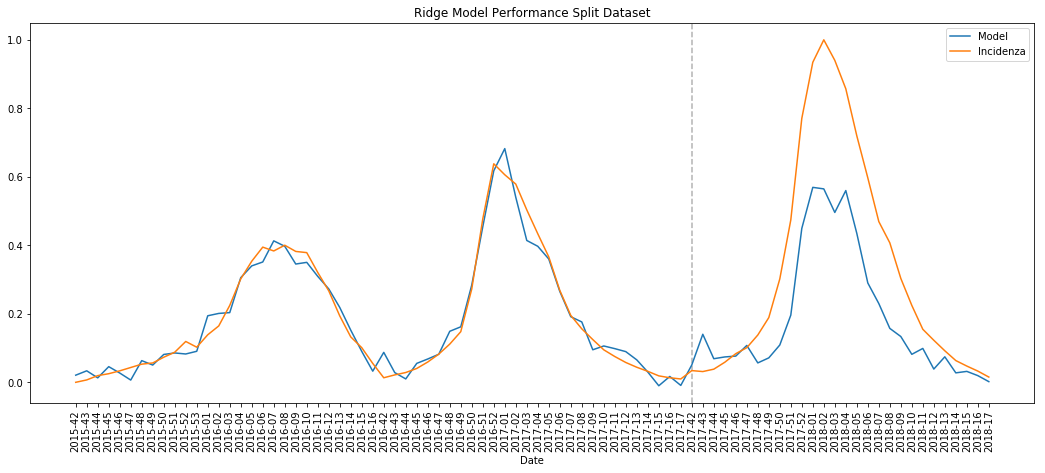

In [53]:
plot_prediction(pd.Series(labels_ridge_train),pd.Series(labels_ridge_test),'Ridge Model Performance Split Dataset',flu_data,all_data)

### Linear Regression Model

In [54]:
reg = LinearRegression().fit(X_train, Y_train)

In [55]:
pd.DataFrame(list(zip(X_test.columns, reg.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.085271
1,Paracetamolo,-0.189438
2,Antibiotico,-0.160826
3,Polmonite,0.185767
4,Rinite medicamentosa,0.018733
5,Virus (biologia),0.025024
6,Influenza,0.259539
7,Tosse post-virale,0.553845
8,Bronchiolite,0.134186
9,Virus respiratorio sinciziale umano,-0.031193


In [56]:
# Train Set
linear_predict_train=reg.predict(X_train)

lin_mse=mean_squared_error(Y_train,linear_predict_train)
lin_rmse=sqrt(lin_mse)

print("R^2: {}".format(reg.score(X_train, Y_train)))
print('MSE:', lin_mse)
print('RMSE:', lin_rmse)
print('AIC:', aic(all_data.iloc[:56,1], linear_predict_train,all_data.iloc[56:,1:]))

R^2: 0.9785128244202225
MSE: 0.0006420591520807378
RMSE: 0.025338886164958746
AIC: 36.08272359144871


In [57]:
# Test Set
linear_predict_test=reg.predict(X_test)

lin_mse=mean_squared_error(Y_test,linear_predict_test)
lin_rmse=sqrt(lin_mse)

print("R^2: {}".format(reg.score(X_test, Y_test)))
print('MSE:', lin_mse)
print('RMSE:', lin_rmse)
print('AIC:', aic(all_data.iloc[56:,1], linear_predict_test,all_data.iloc[56:,1:]))

R^2: 0.7926698847451256
MSE: 0.02157577414353737
RMSE: 0.14688694340729325
AIC: 38.125884294725


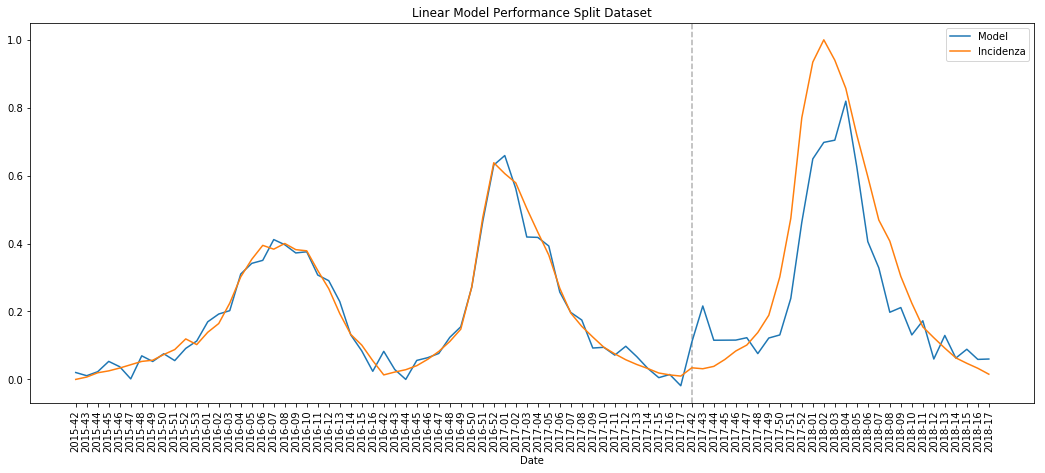

In [58]:
plot_prediction(pd.Series(linear_predict_train),pd.Series(linear_predict_test),'Linear Model Performance Split Dataset',flu_data,all_data)

The models above clearly convey the inconsistencies of Method 1, which relied on the entire dataset as a training set. As a matter of fact, the goodness of fit value indeed decreases in most models, e.g. the LASSO and the Ridge Models (with a 0.12 and 0.58 R-squared on the Test set, respectively).

The best-performing models are still the Poisson and the Linear Regression Models, whose goodness of fit is 0.95 and 0.79, respectively. The better performance of these models might be explained by the number of variables included in the model. Indeed, the trade-off between over-fitting and the removal of multicollinearity: on one hand, the LASSO and Ridge Models tend to eliminate those independent variables that present some sort of collinearity among them (as previously stated) hence resulting in an extremely small pool of potential variables (in this case, both models selected only 3 explanatory variables out of 20). This process attempts to eliminate multicollinearity as well as over-fitting, but it ends up building a model on such few variables, that they are not enough to meaningfully explain or have any significant impact on the prediction.

On the other hand, the Poisson and Linear Regression (which does not implement any feature selection method) Models focus on the explanatory power of the variables, thereby producing higher levels of over-fitting. It is important to notice that the Poisson Model implemented a LASSO feature selection scheme (which was included as one of the parameters of the estimator) - this however did not discard as many variables as the pure LASSO Model.

The high performance of the Poisson Model could be intrinsically related to the nature of our data. Since the Poisson distribution deals with count data, it models the number of times an event occurs over time in such a way that provides more accurate results than a simpler Linear Regression method. 

Furthemore, given the small pool of available data, we implemented a cross-validation method for all models apart from the Linear Regression. We also managed to include a validation set in the Poisson Model, which is built from a data resampling with replacement of the full dataset.

## Models adjusted for auto-correlation (Part 3.2)

Having determined that the best approach to build a more accurate model is to split the small available dataset into a train and a test set, it is now appropriate to include additional features to the models, in order to account for certain inherent characteristics of the dataset. As time series data have a natural temporal ordering, it is fair to say that observations close together in time will be more closely related than observations further apart, resulting in certain degrees of auto-correlation, as well as seasonal patterns.

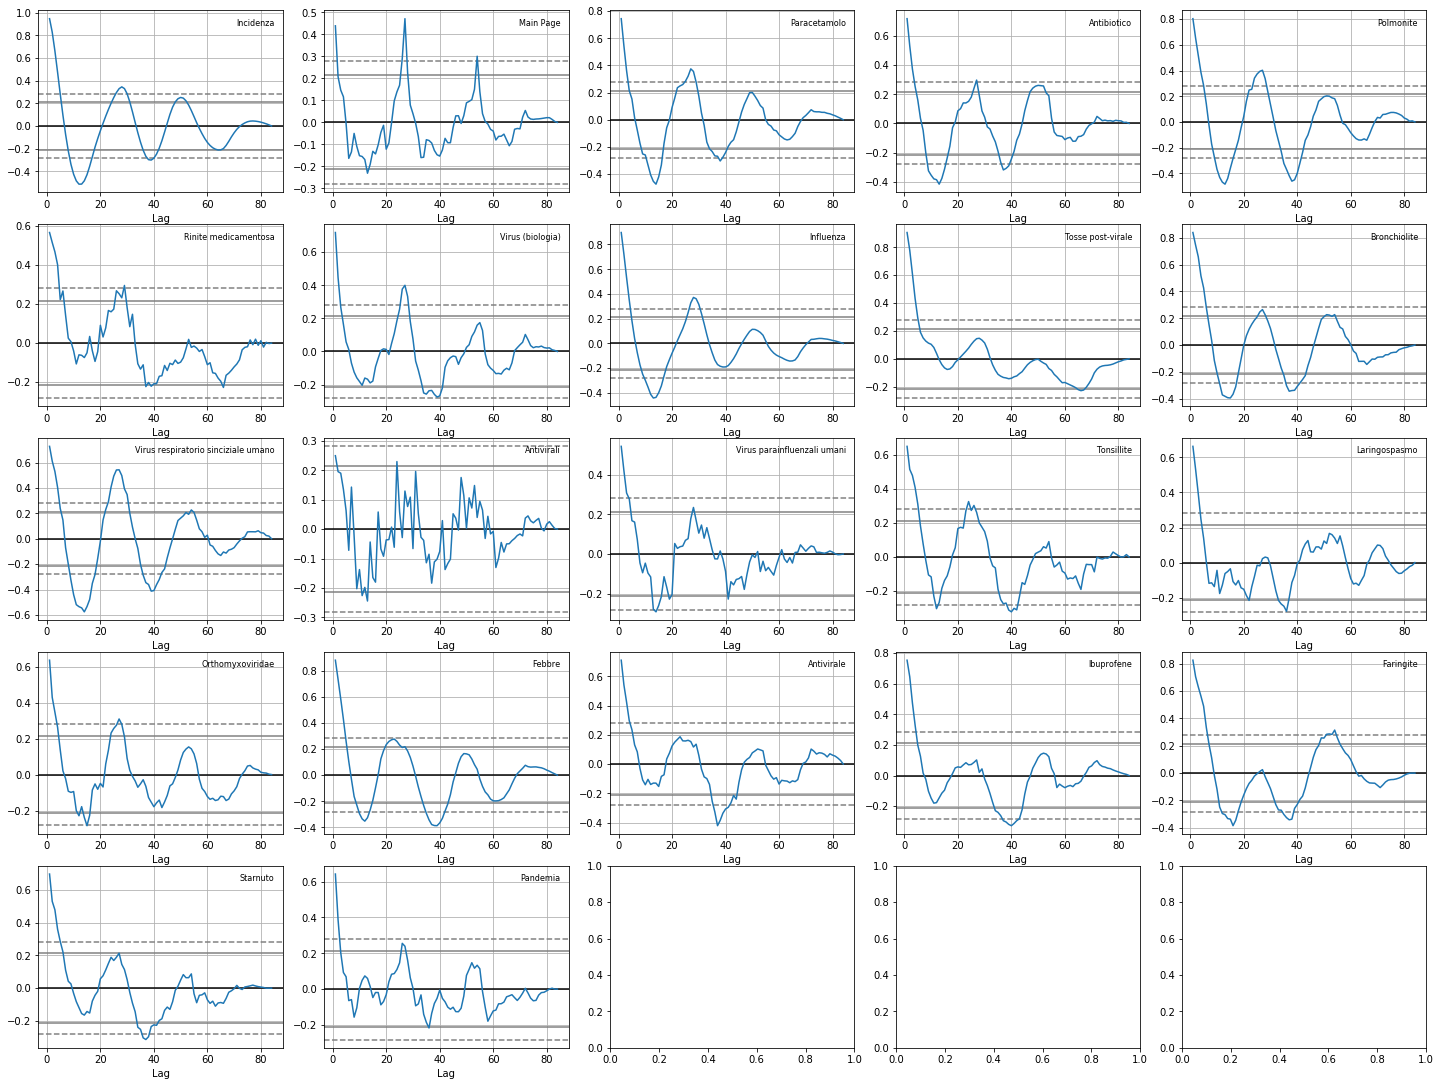

In [59]:
# comparison of variables' pageviews with real ILI cases
def label(ax, string):
    ax.set(title='', ylabel='')
    ax.annotate(string, (1, 1), xytext=(-8, -8), ha='right', va='top',
                size=8, xycoords='axes fraction', textcoords='offset points')


fig, axes = plt.subplots(nrows=len(all_data.columns)//4,ncols=5, figsize=(20, 15))
fig.tight_layout()

for i in range(0, len(all_data.columns)):
        axes.flatten()[i].set(title='', xlabel='')
        autocorrelation_plot(all_data.iloc[:,i],ax=axes.flatten()[i])
        label(axes.flatten()[i], all_data.columns[i])

plt.show()

The plots above clearly show varying levels of autocorrelation among variables, that are present both in the dependent variable, Incidenza, and in the majority of the explanatory variables.

A way in which McIver and Brownstein account for these features is by building "models excluding data at key time periods which reflect higher than normal ILI activity or Wikipedia article traffic" (e.g. Pandemic Swine Flu and unusually severe influenza seasons). The rationale behind this choice is to investigate whether spikes in Wikipedia activity affect the accuracy of the model. Nevertheless, they found that models that did include spikes in Wikipedia activity did not significantly differ from those that did not. Among the possible techniques one could use to control for seasonality and auto-correlation, one of the most straightforward is to account for lags in the variables of interest, by including their values at time t-1 (or further) in the models, which is the technique implemented in this project.

The main idea behind the introduction of the variables' lags is to somehow control for seasonal patterns and trends by adding potentially significant features to the models analysed. It is however important to note that by doing so, we also introduce a certain degree of multi-collinearity among variables, which needs to be accounted for. Furthermore, adding extra variables does not necessarily imply their significance - as a matter of fact, most of them are expected not to be significant in the model.

Although we have previously stated that the Poisson (+ LASSO) and the Linear Regression Models seem to be the best performing, we decided to examine the performance of all four models, to check whether LASSO's and Ridge's feature selection methods somehow make up for the newly-added multi-collinearity.

In [60]:
def lag_function(dataset):
    '''computes the lagged values of each variable for a given dataset'''
    X_lag = dataset
    for i in X_lag.columns:
        X_lag[i + "_lag"] = X_lag[i].shift(-1)
    X_lag = X_lag.fillna(0)
    return X_lag

In [61]:
all_data_lag= lag_function(all_data)

### Poisson GLM + Lasso

In [62]:
train_ = all_data_lag.iloc[:56,:]
test_ = all_data_lag.iloc[56:,:]

predictors = list(train_.columns[1:])
y = train_.columns[0]

glm_model = H2OGeneralizedLinearEstimator(nfolds=10, remove_collinear_columns=True, family='poisson', link='log', lambda_search=True, alpha=1)
glm_model.train(x=predictors, y=y, training_frame=h2o.H2OFrame(all_data))

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm Model Build progress: |███████████████████████████████████████████████| 100%


In [63]:
table = glm_model._model_json['output']['coefficients_table']
table.as_data_frame()

,names,coefficients,standardized_coefficients
0,Intercept,-3.599448,-1.922639
1,Main Page,0.000000,0.000000
2,Paracetamolo,0.000000,0.000000
3,Antibiotico,0.000000,0.000000
4,Polmonite,0.000000,0.000000
5,Rinite medicamentosa,0.000000,0.000000
6,Virus (biologia),0.582251,0.107954
7,Influenza,0.124609,0.023319
8,Tosse post-virale,0.519931,0.093005
9,Bronchiolite,0.000000,0.000000


In [64]:
test_prediction = glm_model.predict(h2o.H2OFrame(test_)).as_data_frame()
train_prediction = glm_model.predict(h2o.H2OFrame(train_)).as_data_frame()

h2o_mse_train=mean_squared_error(train_.Incidenza.values, train_prediction)
h2o_rmse_train = sqrt(h2o_mse_train)
h2o_mse_test=mean_squared_error(test_.Incidenza.values, test_prediction)
h2o_rmse_test = sqrt(h2o_mse_test)
print('\n')
print('R^2 Train:', glm_model.r2())
print('\n')
print('Train MSE:', h2o_mse_train)
print('Train RMSE:', h2o_rmse_train)
print('Train AIC:', aic(all_data_lag.iloc[:56,1], train_prediction, all_data_lag.iloc[:56,1:]))
print('\n')
print('Performance on Test Set:')
print('\n')
glm_model.model_performance(test_data=h2o.H2OFrame(test_))

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


R^2 Train: 0.9627357320990899


Train MSE: 0.0014576319453164278
Train RMSE: 0.03817894636205179
Train AIC: 71.96356224710162


Performance on Test Set:


Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 0.003548014092247332
RMSE: 0.059565208740063456
MAE: 0.045417215040651986
RMSLE: 0.041762085640558326
R^2: 0.9659057338965586
Mean Residual Deviance: 0.013495301136638192
Null degrees of freedom: 27
Residual degrees of freedom: 10
Null deviance: 9.602690480834736
Residual deviance: 0.3778684318258694
AIC: 66.65658125755587


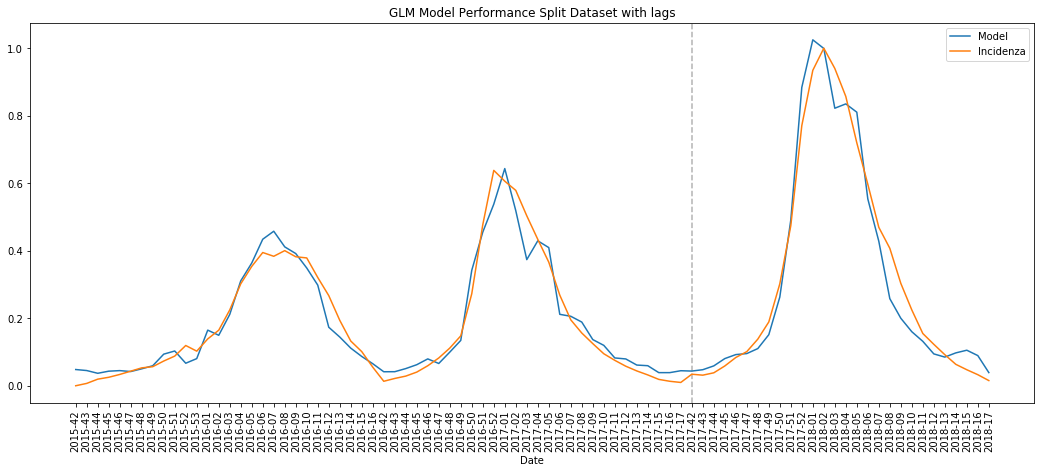

In [65]:
plot_prediction(train_prediction,test_prediction,'GLM Model Performance Split Dataset with lags',flu_data,all_data_lag)

### LASSO Model

In [66]:
X_train=all_data_lag.iloc[:56,1:]
Y_train=all_data_lag['Incidenza'][:56]
X_test=all_data_lag.iloc[56:,1:]
Y_test=all_data_lag['Incidenza'][56:]

In [67]:
grid = GridSearchCV(estimator=Lasso(), param_grid={'alpha': np.arange(0.0001,1,0.0001)},n_jobs=-1,cv=10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.000e-04, 2.000e-04, ..., 9.998e-01, 9.999e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
Lasso_model_final= Lasso(alpha=grid.best_estimator_.alpha).fit(X_train, Y_train)
pd.DataFrame(list(zip(X_train.columns, Lasso_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.000000
1,Paracetamolo,0.000000
2,Antibiotico,0.000000
3,Polmonite,0.000000
4,Rinite medicamentosa,0.006144
5,Virus (biologia),-0.000000
6,Influenza,0.000000
7,Tosse post-virale,0.200945
8,Bronchiolite,-0.000000
9,Virus respiratorio sinciziale umano,0.000000


In [69]:
# Train Set
labels_lasso_train=Lasso_model_final.predict(X_train)

lasso_mse=mean_squared_error(Y_train,labels_lasso_train)
lasso_rmse = sqrt(lasso_mse)

print("R^2 train: {}".format(Lasso_model_final.score(X_train, Y_train)))
print('MSE train:', lasso_mse)
print('RMSE train:', lasso_rmse)
print('AIC train:', aic(all_data.iloc[:56,1], labels_lasso_train,all_data.iloc[:56,1:]))

R^2 train: 0.968172376448758
MSE train: 0.0009510424910981729
RMSE train: 0.03083897681665481
AIC train: 80.10356542879771


In [70]:
# Test Set
labels_lasso_test = Lasso_model_final.predict(X_test)

lasso_mse=mean_squared_error(Y_test,labels_lasso_test)
lasso_rmse = sqrt(lasso_mse)

print("R^2 test: {}".format(Lasso_model_final.score(X_test, Y_test)))
print('MSE test:', lasso_mse)
print('RMSE test:', lasso_rmse)
print('AIC test:', aic(all_data_lag.iloc[56:,1], labels_lasso_test,all_data_lag.iloc[56:,1:]))

R^2 test: 0.7719942583047497
MSE test: 0.023727379788502707
RMSE test: 0.1540369429341634
AIC test: 81.85063481368282


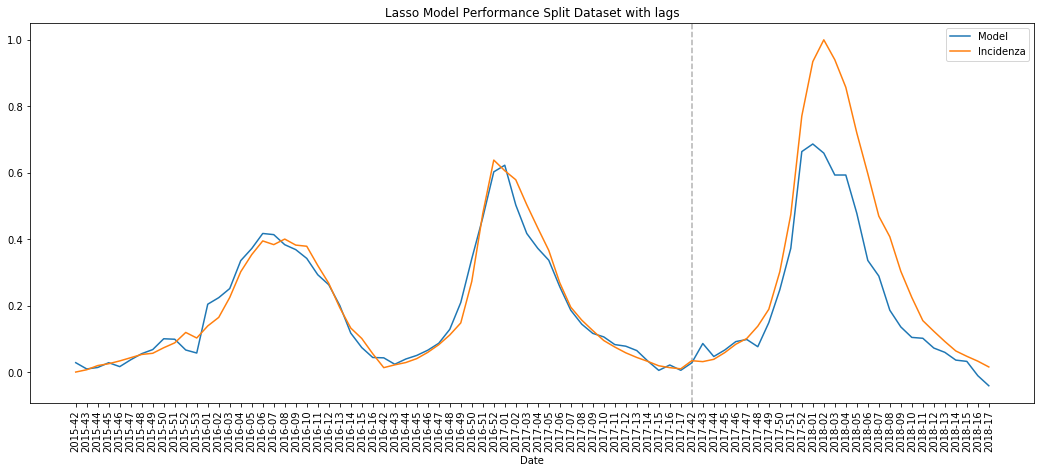

In [71]:
plot_prediction(pd.Series(labels_lasso_train),pd.Series(labels_lasso_test),'Lasso Model Performance Split Dataset with lags',flu_data,all_data_lag)

### Ridge Model


In [72]:
clf = GridSearchCV(estimator=Ridge(), param_grid={'alpha': np.arange(0.05,3,0.01)},cv=10,n_jobs=-1)
clf.fit(X_train, Y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([0.05, 0.06, ..., 2.98, 2.99])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [73]:
Ridge_model_final= Ridge(alpha=clf.best_estimator_.alpha).fit(X_train, Y_train)
pd.DataFrame(list(zip(X_train.columns, Lasso_model_final.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.000000
1,Paracetamolo,0.000000
2,Antibiotico,0.000000
3,Polmonite,0.000000
4,Rinite medicamentosa,0.006144
5,Virus (biologia),-0.000000
6,Influenza,0.000000
7,Tosse post-virale,0.200945
8,Bronchiolite,-0.000000
9,Virus respiratorio sinciziale umano,0.000000


In [74]:
# Train Set
labels_ridge_train=Ridge_model_final.predict(X_train)

ridge_mse=mean_squared_error(Y_train,labels_ridge_train)
ridge_rmse = sqrt(ridge_mse)

print("R^2 train: {}".format(Ridge_model_final.score(X_train, Y_train)))
print('MSE train:', ridge_mse)
print('RMSE train:', ridge_rmse)
print('AIC train:', aic(all_data_lag.iloc[:56,1], labels_ridge_train,all_data_lag.iloc[:56,1:]))

R^2 train: 0.9278476715203471
MSE train: 0.0021559866103526676
RMSE train: 0.04643260288151707
AIC train: 80.12208980456283


In [75]:
# Test Set
labels_ridge_test = Ridge_model_final.predict(X_test)

ridge_mse=mean_squared_error(Y_test,labels_ridge_test)
ridge_rmse = sqrt(ridge_mse)
print("R^2 test: {}".format(Ridge_model_final.score(X_test, Y_test)))
print('MSE test:', ridge_mse)
print('RMSE test:', ridge_rmse)
print('AIC test:', aic(all_data_lag.iloc[56:,1], labels_ridge_test,all_data_lag.iloc[56:,1:]))

R^2 test: 0.5596021687669538
MSE test: 0.04582992744834495
RMSE test: 0.21407925506303724
AIC test: 81.64117001769243


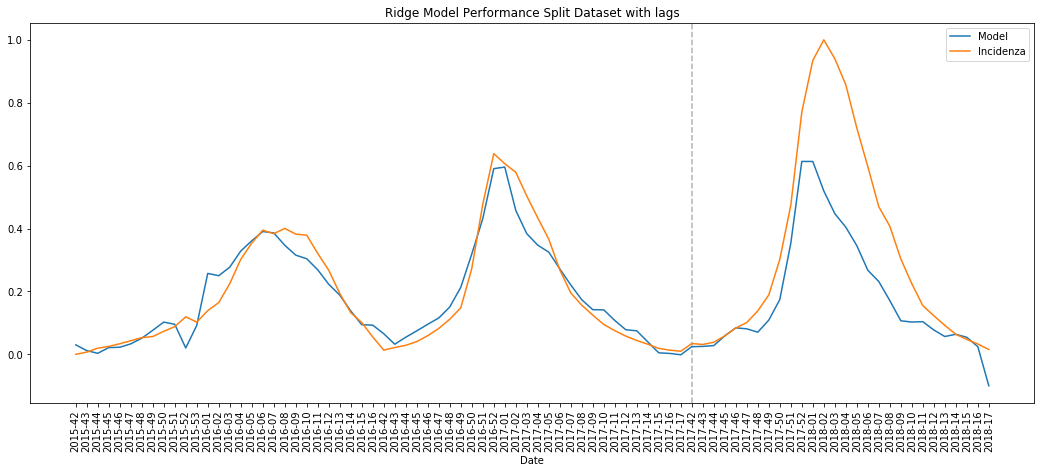

In [76]:
plot_prediction(pd.Series(labels_ridge_train),pd.Series(labels_ridge_test),'Ridge Model Performance Split Dataset with lags',flu_data,all_data)

### Linear Regression Model

In [77]:
reg = LinearRegression().fit(X_train, Y_train)

In [78]:
pd.DataFrame(list(zip(X_test.columns, reg.coef_)), columns=['features', 'estimated_coeff'])

,features,estimated_coeff
0,Main Page,-0.185988
1,Paracetamolo,-0.182670
2,Antibiotico,0.022071
3,Polmonite,-0.127958
4,Rinite medicamentosa,0.034614
5,Virus (biologia),0.062986
6,Influenza,0.021835
7,Tosse post-virale,0.596480
8,Bronchiolite,0.012672
9,Virus respiratorio sinciziale umano,-0.026195


In [79]:
# Train Set
linear_predict_train=reg.predict(X_train)

lin_mse=mean_squared_error(Y_train,linear_predict_train)
lin_rmse=sqrt(lin_mse)

print("R^2: {}".format(reg.score(X_train, Y_train)))
print('MSE:', lin_mse)
print('RMSE:', lin_rmse)
print('AIC:', aic(all_data_lag.iloc[:56,1], linear_predict_train,all_data_lag.iloc[56:,1:]))

R^2: 0.9953363485080846
MSE: 0.0001393547565794252
RMSE: 0.011804861565449432
AIC: 80.07980419247562


In [80]:
# Test Set
linear_predict_test=reg.predict(X_test)

lin_mse=mean_squared_error(Y_test,linear_predict_test)
lin_rmse=sqrt(lin_mse)

print("R^2: {}".format(reg.score(X_test, Y_test)))
print('MSE:', lin_mse)
print('RMSE:', lin_rmse)
print('AIC:', aic(all_data_lag.iloc[56:,1], linear_predict_test,all_data_lag.iloc[56:,1:]))

R^2: 0.8343232846442092
MSE: 0.01724111997413087
RMSE: 0.13130544533312724
AIC: 82.6685331524112


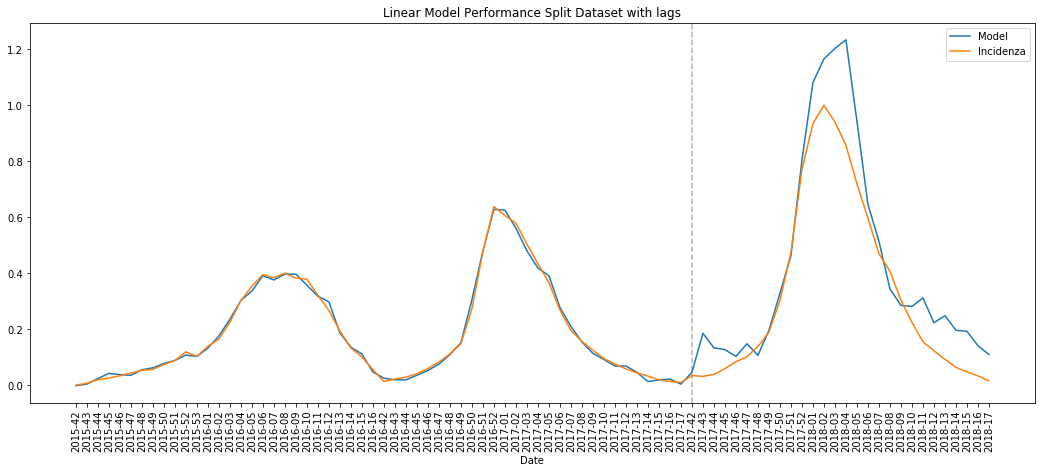

In [81]:
plot_prediction(pd.Series(linear_predict_train),pd.Series(linear_predict_test),'Linear Model Performance Split Dataset with lags',flu_data,all_data)

As expected, not all lagged variables proved to be significant in our models, leading to an increase of both multi-collinearity and noise. Among those that were included, only few variables related to inflammations (e.g. 'Faringite' and 'Bronchiolite'), viruses (e.g. 'Virus respiratorio sinciziale umano') and collateral effects resulting from a misuse of prescribed medications (e.g. 'Rinite medicamentosa') were significant and hence kept by our models. Being the only model without any feature selection control, the Linear Regression proved to be the only one to account for the explanatory power (even as low as 0.002983) of all variables. Despite the fact that it showed a high level of overfitting in the training part, the Linear Regression Model was able to outperform models with strong feature selection criteria - and therefore with much less noise, such as the LASSO and Ridge Models.

Overall model performance increased, with the goodness of fit rising to 0.55 in the worst-performing model (Ridge), and to 0.96 in the best-performing one - Poisson. In the same way, the Mean Squared Error was lower than 0.04 in all models. Concerning the relative quality of the statistical models for this given dataset, the Poisson Model presented the best AIC coefficient (= 0.66), compared to the other models (AIC > 80). Therefore, in relative terms, the Poisson Model appears to have the best performance.

### Discussion

Despite the overall increase in model performance caused by the introduction of lagged variables, there are still a few points to address when discussing the quality of the statistical models used in this project.

Since the goal of this project was to try to reproduce the results (i.e. obtain accurate predictions) of McIver and Brownstein's paper for Italy, we attempted to build a model that would be as close as possible to the one described in the authors' paper, and compared it with other potentially valid models (LASSO, Ridge and Linear Regression).
In particular, the Poisson model was built taking into account certain techniques and details of the paper's model, such as controls and measures of comparison.
The resulting model was a Poisson model that used a log-link function, validated using not only cross-validation methods, but also a resampling technique (the bootstrap), similar to the jackknife technique implemented by McIver and Brownstein on the validation set; though it was eventually removed, as it did not bring an evident increase to the model's performance.
The model was also trained to remove collinear observations and used LASSO as a feature selection method.

Although the authors illustrate various methods to account for autocorrelation, as previously mentioned, the only technique implemented in this paper to control for seasonal patterns was to add lagged variables (of both Incidence and the independent variables) to the model.
The Akaike Information Criterion (AIC) was used to compare the models presented in this paper, but could not be used as a metre of comparison with the quality of the models in McIver and Brownstein's paper as it is reflective of the dataset used.

With regards to the data used, the authors did have a larger amount of observations to train and test their predictions - allowing for a smoother (and arguably easier) way to identify the weaknesses of their model. Unlike them, we did not have spikes in our pageview data corresponding to real-world events affecting higher-than-usual Wikipedia article traffic, such as the Swine Flu Pandemic of 2009 or unusually severe influenza season, which is why we did not attempt to exclude key time periods from our models during the training phase.

Out of the models presented in the project, the Poisson is not only the best-performing, but also the one that predicts (more or less accurately) real ILI activity in Italy. This could be arguably due to the way the Poisson distribution coupled with a log-link function model the data, as discussed in previous sections.
Nevertheless, our final model does not predict ILI cases as accurately as McIver and Brownstein's model. The reason for this is twofold: on one hand, since the predictions depend on the quantity of available training data, the model could be improved by simply including more observations (i.e. analysing a longer time period). However the problem with this is that Wikipedia does not keep publicly-available data for longer than three years, meaning that one could not extend the training set to include previous years. On the other hand, the lower level of reliability could be explained by the techniques used: as stated above, we attempted to implement similar techniques to those used in the paper (e.g. the bootstrap instead of the jackknife for the validation set), which may or may not have been as accurately tuned to improve the training phase and the predictions as they were in McIver and Brownstein's work.

Finally, to quote the authors' paper: "as with any study using non-traditional sources of information to make estimations or predictions, there is always some measure of noise in the gathered information.", which could concern the location of the accesses to Wikipedia pages, and could be expanded to explain how not all independent variables truly add any significance or improvement to the model.

Main Paper:  D.J. McIver & J. S. Brownstein (2014), "Wikipedia Usage Estimates Prevalence of Influenza-Like Illness in the United States in Near Real-Time", PLoS Comput Biol 10(4): e1003581